# Kostky

* seznámení s knihovnou [empiricaldist](https://github.com/AllenDowney/empiricaldist)
* viz knihu: [A.B.Downey: Think Bayes](http://allendowney.github.io/ThinkBayes2)

## Knihovna empiricaldist

**`class Distribution(pandas.Series)`**

* abstraktní třída rozdělení odvozená od pandas.Series

* `.qs`, `.ps` — np.array, definiční obor (index), obor hodnot

* `__init__(ps, qs)` — konstruktor konzistentní s `pandas.Series(data, index)`

* `transform()` — override metoda modifikuje index (.qs) nikoli hodnoty (.ps)

**`class Pmf(Distribution)`**

* pravděpodobnostní funkce, aka hustota pro diskrétní jevy (Probability mass function)

* `.from_seq(seq: np.array, normalize=True, sort=True)` — vytvoří rozdělení hodnot z dat
* `.normalize()` — normalizuje na součet pravděpodobností 1
* `.plot() .bar()` — nakreslí plt.plot resp. plt.barplot
* `.mean(), .var(), .sum(), .std(), .mode(), .median(), .max_prob()` — statistiky rozdělení
* `.quantile(ps), .credible_interval(p)` — kvantily a bayesovský interval spolehlivosti (centrální pstní masa míry p)
* `.choice(size=1) .sample(n=10)` — náhodný výběr z rozdělení
* `.add_dist(pfm), .sub_dist(), .mul_dist(), .div_dist()` 
  * rozdělení součtu, rozdílu, součinu, podílu rozdělení
* `.lt_dist(pmf), .le_dist, .gt_dist, .ge_dist, eq_dist(), ne_dist()`  
  * porovnání pravděpodobností, že z jednoho rozdělení vyjde nižší/vyšší, stejná nebo různá hodnota než ze druhého
* `.make_joint(pmf)` — sdružené rozdělení (2D) za předpokladu nezávislosti
* `.conditional(i,val), marginal(i)` — podmíněné / marginální rozdělení (i-tá dimenze)
* `.update(likelihood, data)` — bayesovský update 
  * `likelihood(data, hypo)` — funkce, co vrací věrohodnost data pro všechny hypo z qs 
* `.make_cdf()` — převod hustoty na distribuční funkci

**`class Cdf(Distribution)`**

* distribuční funkce (Cumulative distribution function)

* `.from_seq(seq: np.array, normalize=True, sort=True)` — vytvoří distr. funkci ze sekvence hodnot
* `.normalize()` — normalizuje na kumulativní součet pravděpodobností 1
* `.plot(), .step()` — nakreslí plt.plot 
* `.forward(), .inverse()` — vyhodnocení Cdf jako interpolace funkce qs → ps a naopak




In [156]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from empiricaldist import Pmf

def decor(title):
    plt.xlabel('x')
    plt.ylabel('PMF')
    plt.title(title)

#### 1k6 — šestistěnná kostka

* hod běžnou kostkou na člověče zezlob se

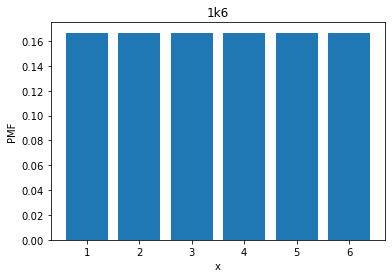

In [157]:
p1k6 = Pmf.from_seq(np.arange(1,7))
p1k6
p1k6.bar();
#p1k6.plot();
decor('1k6')

In [158]:
print(p1k6.mean())
print(p1k6.std())

3.5
1.707825127659933


#### 2k6 — dvě šestistěnné kostky

* součet dvou hodů šestistěnnou kostkou (osadníci v katanu)

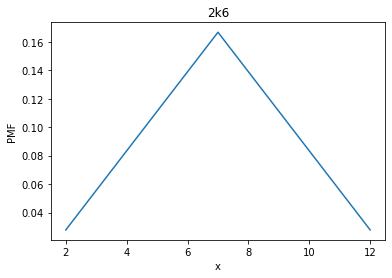

In [159]:
p2k6 = p1k6.add_dist(p1k6)
p2k6.plot();
decor('2k6')

### 10k6 vs. 6k10

* Hrajete kostky. Před vámi leží dvě hromádky kostek 10k6 a 6k10.
* Volíte hromádku, soupeř dostane druhou, hodíte, vyhrává hráč s vyšším součtem.
* Kterou hromádku zvolíte?

#### 10k6 — deset šestistěnných kostek

* Vytvořte rozdělení součtu hodu deseti šestistěnnými kostkami.
  * Jaké je maximum, jaká je střední hodnota?

Max: 60
Mean: 35.00


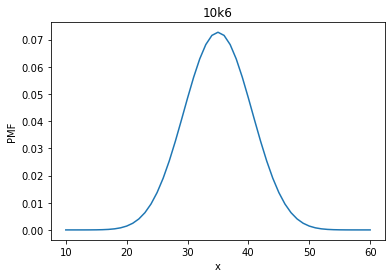

In [160]:
def n_dices(dice, N):
    res = dice.copy()
    for _ in range(N-1):
        res = res.add_dist(dice) 
    return res    

p10k6 = n_dices(p1k6, 10)

p10k6.plot();    
decor('10k6')
print(f'Max: {p10k6.qs.max()}')
print(f'Mean: {p10k6.mean():.2f}')

#### 6k10 — šest desetistěnných kostek
* Vytvořte rozdělení součtu hodu deseti šestistěnnými kostkami.
  * Jaké je maximum, jaká je střední hodnota?

Max: 60
Mean: 33.00


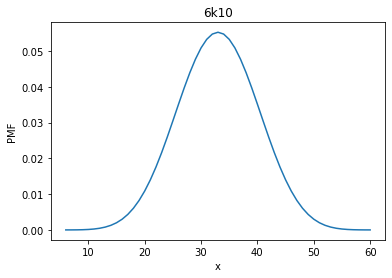

In [161]:
p1k10 = Pmf.from_seq(np.arange(1,11))
p6k10 = n_dices(p1k10, 6)

p6k10.plot();    
decor('6k10')
print(f'Max: {p6k10.qs.max()}')
print(f'Mean: {p6k10.mean():.2f}')

#### Rozdíl mezi 10k6 a 6k10

* Jaké je rozdělení rozdílu mezi 10k6 a 6k10
  * Jaká je střední hodnota rozdílu
* Jaká je pravděpodobnost, že 10k6 bude vyšší než 6k10?


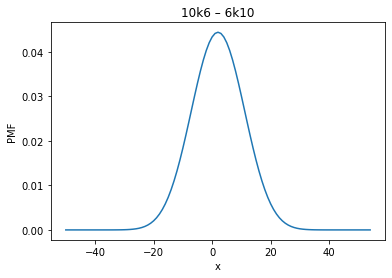

In [162]:
p_diff = p10k6.sub_dist(p6k10)
p_diff.plot();
decor('10k6 – 6k10')

In [163]:
p_diff.mean()

1.9999999999999996

In [164]:
p_diff[p_diff.qs > 0].sum()

0.5663577772590578

In [165]:
p10k6.gt_dist(p6k10)

0.566357777259058

### 1k6+

* Jaké je rozdělení hodu 1k6+, tedy hodu, kdy po šestce házím znovu?

* Jaká je střední hodnota?

* Která z kostek 1kN pro N v [2,10] má nejvyšší střední hodnotu?

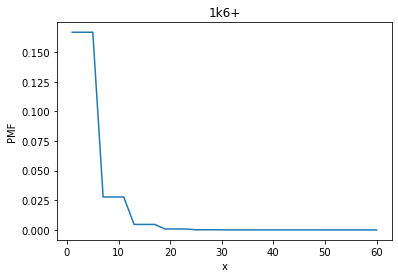

In [166]:
vals = (p1k6.qs, p1k6.ps)
bonus = (p1k6.qs, p1k6.ps)

def generate_1kNp(N = 6, deep = 10):
    p=[]
    q=[]
    prob = 1
    val=1
    for i in range(deep):
        pp = prob/N
        for j in range(N-1):
            q.append(val)
            p.append(pp)
            val +=1
        val +=1
        prob = pp   
    
    q.append(val-1)
    p.append(prob)
    
    p1kNp = Pmf(p,q)
    p1kNp.normalize()
    return p1kNp

p1k6p = generate_1kNp(6)

p1k6p.plot();
decor('1k6+')

In [167]:
p1k6p.mean()

4.199999930539679

2     2.997070
3     2.999949
4     3.333330
5     3.750000
6     4.200000
7     4.666667
8     5.142857
9     5.625000
10    6.111111
dtype: float64


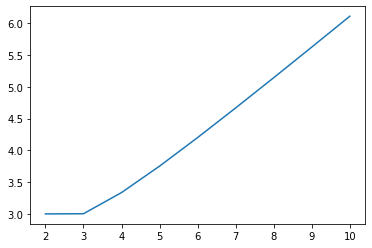

In [168]:
sm = pd.Series(0, index = np.arange(2,11))

for N in sm.index:
    sm.loc[N]=generate_1kNp(N).mean()
    
print(sm)
plt.plot(sm);

### 10k6+ vs 6k10+

* Stejná otázka jen s opakováním hodu po šestce


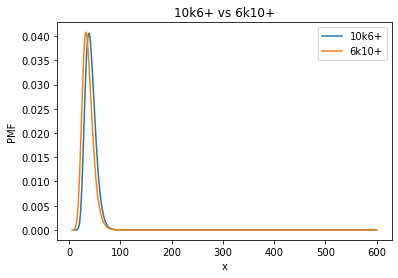

In [176]:
p1k6p = generate_1kNp(6)
p10k6p = n_dices(p1k6p, 10)

p1k10p = generate_1kNp(10)
p6k10p = n_dices(p1k10p, 6)

p10k6p.plot();
p6k10p.plot();
decor('10k6+ vs 6k10+')
plt.legend(['10k6+','6k10+']);

In [171]:
p10k6p.mean()

41.99999930539677

In [172]:
p6k10p.mean()

36.666666663000015